# 0.0. IMPORTS

In [172]:
import math
import warnings
import datetime
import inflection
import numpy                as np
import pandas               as pd
import seaborn              as sns

from scipy                  import stats as ss
from matplotlib             import pyplot as plt
from IPython.core.display   import HTML
from IPython.display        import Image

from sklearn.preprocessing  import RobustScaler, MinMaxScaler

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min(kcorr-1, rcorr-1 ) ) )

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('../datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../datasets/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DATA DESCRIPTION

In [5]:
# create copy df
df1 = df_raw.sample(50000).copy()

## 1.1. Rename Columns

In [6]:
cols_old = df1.columns

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'. format(df1.shape[0]))
print('Number of Columns: {}'. format(df1.shape[1]))

Number of Rows: 50000
Number of Columns: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                               0
day_of_week                         0
date                                0
sales                               0
customers                           0
open                                0
promo                               0
state_holiday                       0
school_holiday                      0
store_type                          0
assortment                          0
competition_distance              130
competition_open_since_month    15863
competition_open_since_year     15863
promo2                              0
promo2_since_week               25016
promo2_since_year               25016
promo_interval                  25016
dtype: int64

## 1.5. Fillout NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
# # Verificando qual o método é mais rápido

# %timeit df1['competition_open_since_month'].apply(lambda x: math.isnan(x))
# %timeit df1['competition_open_since_month'].apply(lambda x: pd.isna(x))
# %timeit df1['competition_open_since_month'].apply(lambda x: np.isnan(x))

In [12]:
# ============================================================== competition_distance ==============================================================

# foi assumida a premissa que todos os valores faltantes de distancia do competidor se deve por conta
# do competidor mais proximo ser muito distante (bem maior que a distancia maxima)

# ===================== competition_distance =====================
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)


# ======================================================= competition_open_since_month/year // promo2_since_week/year =======================================================

# nessa substituicao para os valores faltantes iremos atribuir as datas de venda considerando que o
# tempo desde a a abertura de uma nova competicao ira impactar no aumento e/ou diminuicao das vendas

# ================= competition_open_since_month =================
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1).astype(np.int64())

# ================= competition_open_since_year ==================
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1).astype(np.int64())

# ======================= promo2_since_week ======================
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# ======================= promo2_since_year ======================
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# ================================================================= promo_interval =================================================================

# Substituimos os valores faltantes por 0, em seguida criamos uma coluna definindo se a venda 
# aconteceu no intervalo de promocao ou nao

month_map = {
     1: 'Jan',
     2: 'Feb',
     3: 'Mar',
     4: 'Apr',
     5: 'May',
     6: 'Jun',
     7: 'Jul',
     8: 'Aug',
     9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']] \
                        .apply(lambda x: 0 if x['promo_interval'] == 0 else \
                                       1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [14]:
df1 = df1.assign(
    competition_open_since_month = pd.to_numeric(df1['competition_open_since_month']),
    competition_open_since_year  = pd.to_numeric(df1['competition_open_since_year']),

    promo2_since_week = df1['promo2_since_week'].astype(np.int64()),
    promo2_since_year = df1['promo2_since_year'].astype(np.int64())
)

## 1.7. Descriptive Statistical

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
num_attributes = df1.select_dtypes(['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'standard', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,standard,skew,kurtosis
0,store,1.0,1115.0,1114.0,560.60004,563.0,322.637251,-0.013379,-1.206214
1,day_of_week,1.0,7.0,6.0,4.00268,4.0,1.999698,-0.000219,-1.252470
2,sales,0.0,38025.0,38025.0,5781.90122,5738.5,3875.009594,0.678142,1.930134
3,customers,0.0,4855.0,4855.0,633.20226,609.0,465.175580,1.616586,7.276210
4,open,0.0,1.0,1.0,0.82956,1.0,0.376019,-1.752943,1.072853
5,promo,0.0,1.0,1.0,0.38292,0.0,0.486099,0.481727,-1.768010
6,school_holiday,0.0,1.0,1.0,0.17976,0.0,0.383987,1.668021,0.782326
7,competition_distance,20.0,200000.0,199980.0,5938.74180,2330.0,12573.892983,10.204727,146.778285
8,competition_open_since_month,1.0,12.0,11.0,6.77652,7.0,3.312772,-0.035411,-1.238567
9,competition_open_since_year,1900.0,2015.0,115.0,2010.27988,2012.0,5.759874,-7.854398,132.614034


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

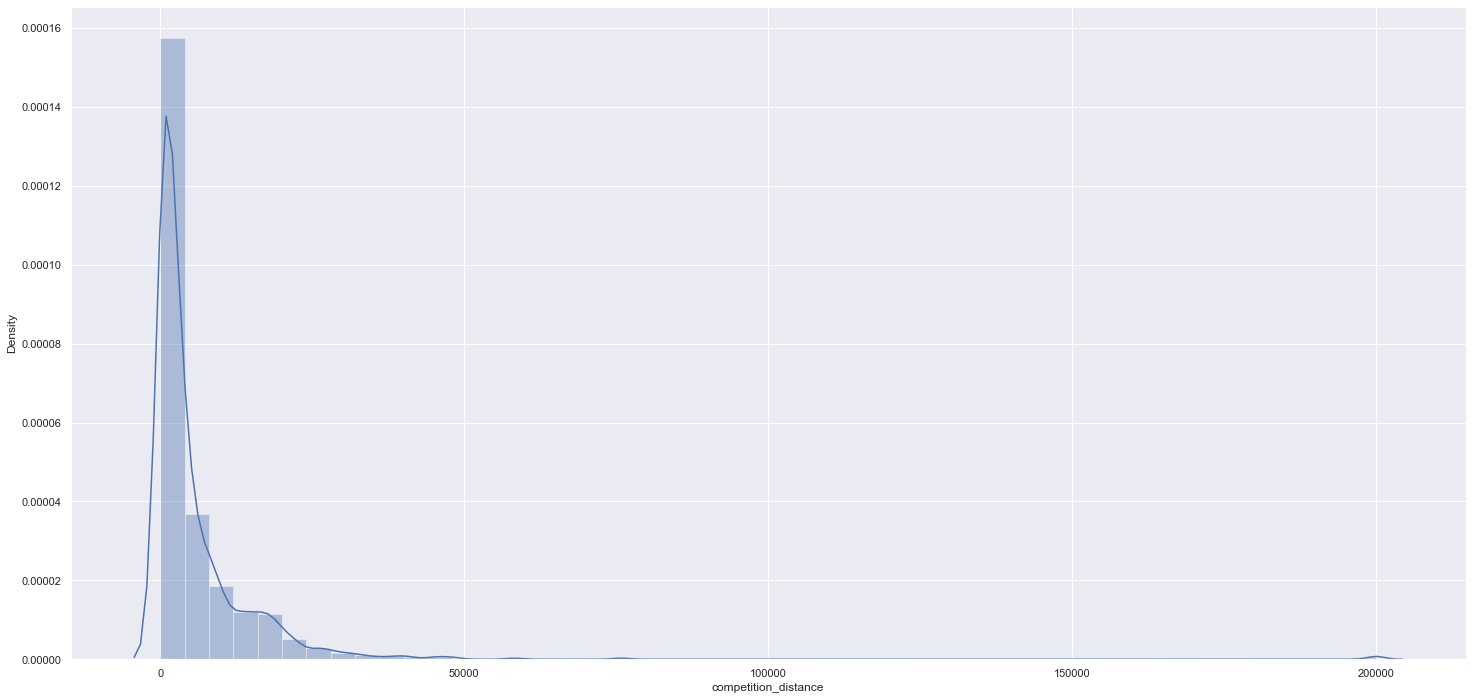

In [18]:
sns.distplot(df1['competition_distance'])

### 1.7.2. Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

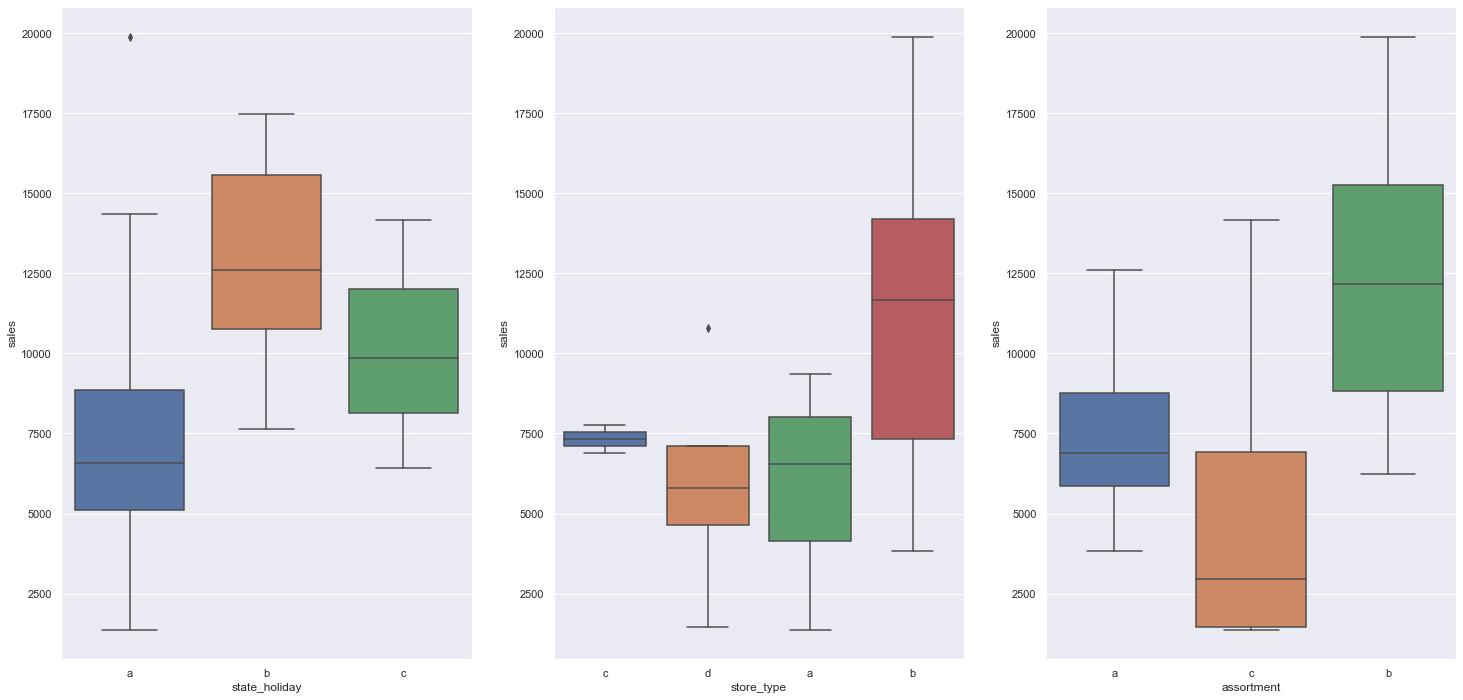

In [20]:
# Outlier = 3x desvio padrao

aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

# 2.0. FEATURE ENGINEERING

## 2.1. Mapa mental de hipoteses

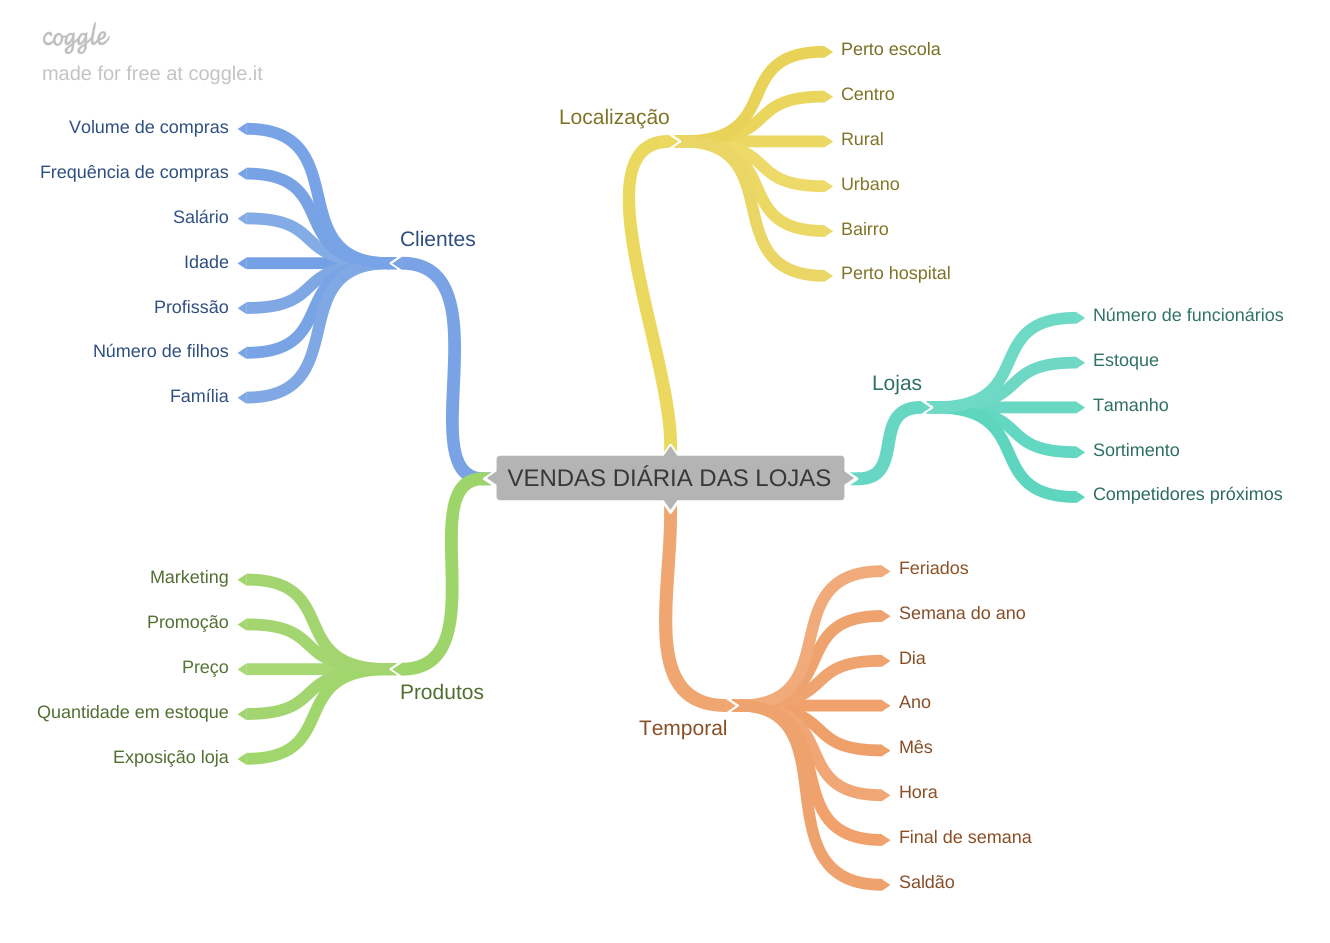

In [21]:
Image('../img/mapa_mental_hipoteses.png')

## 2.2. Criação das hipoteses

In [22]:
df2 = df1.copy()

### 2.2.1. Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposicao de produto deveriam vender mais.

**3.** Lojas com produtos com preco menor deveriam vender mais.

**4.** Lojas com promocoes mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas com mais promocoes consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                 month=x['competition_open_since_month'],
                                                                 day=1), axis=1)

df2['competition_time_month'] = ( ( df2['date'] - pd.to_datetime(df2['competition_since']) )/30 ).apply( lambda x: x.days ).astype( np.int64() )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(np.int64)

# assorment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. FILTRAGEM DE VARIÁVEIS

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
215620,426,1,2015-01-19,4265,616,1,0,regular_day,0,a,basic,250.0,1,2015,0,4,2015,0,Jan,0,2015,1,19,4,2015-03,2015-01-01,0,2015-01-19,0
241498,529,5,2014-12-26,0,0,0,0,christmas,1,d,extended,12920.0,9,2012,0,52,2014,0,Dec,0,2014,12,26,52,2014-51,2012-09-01,28,2014-12-22,0
732136,367,5,2013-09-13,5634,572,1,1,regular_day,0,d,extended,2640.0,9,2012,0,37,2013,0,Sep,0,2013,9,13,37,2013-36,2012-09-01,12,2013-09-09,0
848109,380,6,2013-06-01,13731,1354,1,0,regular_day,0,a,basic,2240.0,5,2013,1,10,2014,"Mar,Jun,Sept,Dec",Jun,1,2013,6,1,22,2013-21,2013-05-01,1,2014-03-03,-40
38252,343,6,2015-06-27,6231,598,1,0,regular_day,0,d,basic,18650.0,4,2004,1,14,2014,"Jan,Apr,Jul,Oct",Jun,0,2015,6,27,26,2015-25,2004-04-01,136,2014-03-31,64


## 3.1. Filtragem das linhas

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [28]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
215620,426,1,2015-01-19,4265,0,regular_day,0,a,basic,250.0,1,2015,0,4,2015,0,2015,1,19,4,2015-03,2015-01-01,0,2015-01-19,0
732136,367,5,2013-09-13,5634,1,regular_day,0,d,extended,2640.0,9,2012,0,37,2013,0,2013,9,13,37,2013-36,2012-09-01,12,2013-09-09,0
848109,380,6,2013-06-01,13731,0,regular_day,0,a,basic,2240.0,5,2013,1,10,2014,1,2013,6,1,22,2013-21,2013-05-01,1,2014-03-03,-40
38252,343,6,2015-06-27,6231,0,regular_day,0,d,basic,18650.0,4,2004,1,14,2014,0,2015,6,27,26,2015-25,2004-04-01,136,2014-03-31,64
1002497,898,1,2013-01-14,5908,0,regular_day,0,a,basic,18540.0,1,2013,0,3,2013,0,2013,1,14,3,2013-02,2013-01-01,0,2013-01-14,0


# 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS

In [29]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1 Response Variable

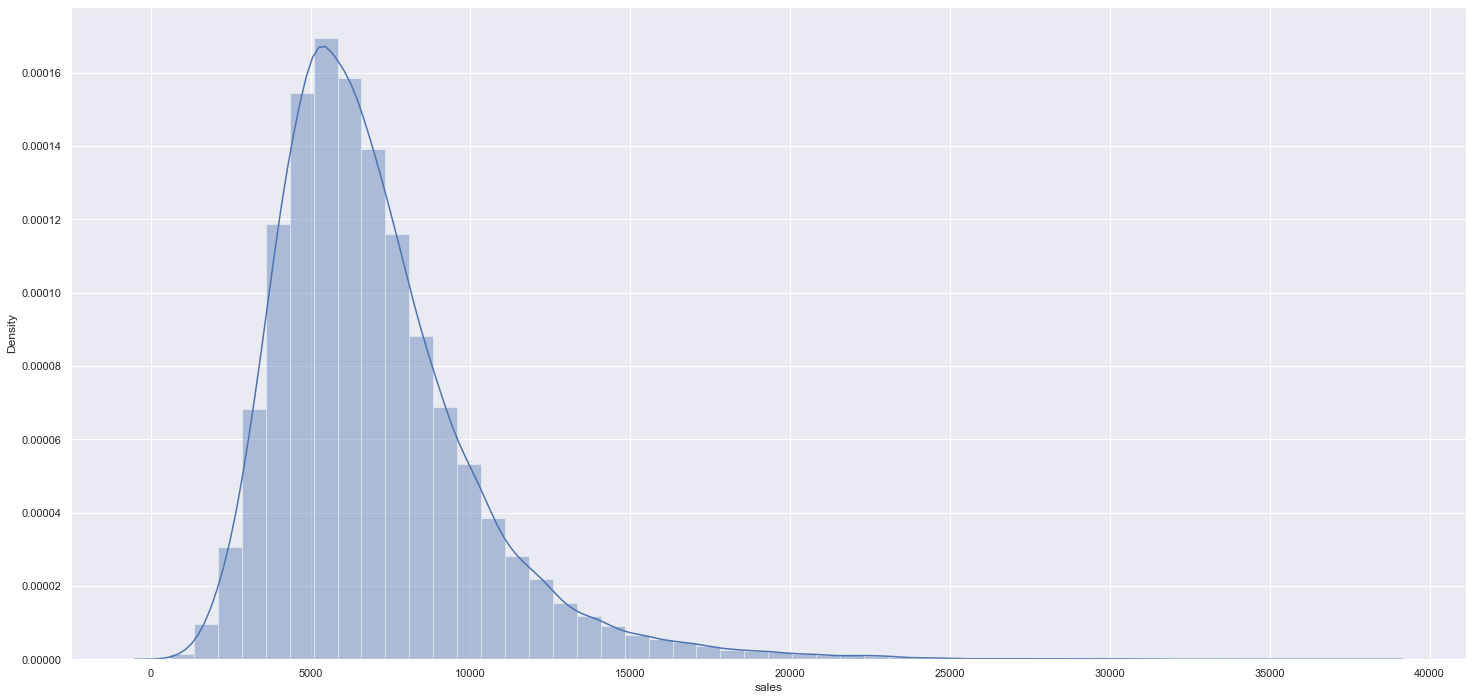

In [30]:
sns.distplot(df4['sales']);

### 4.1.2 Numerical Variable

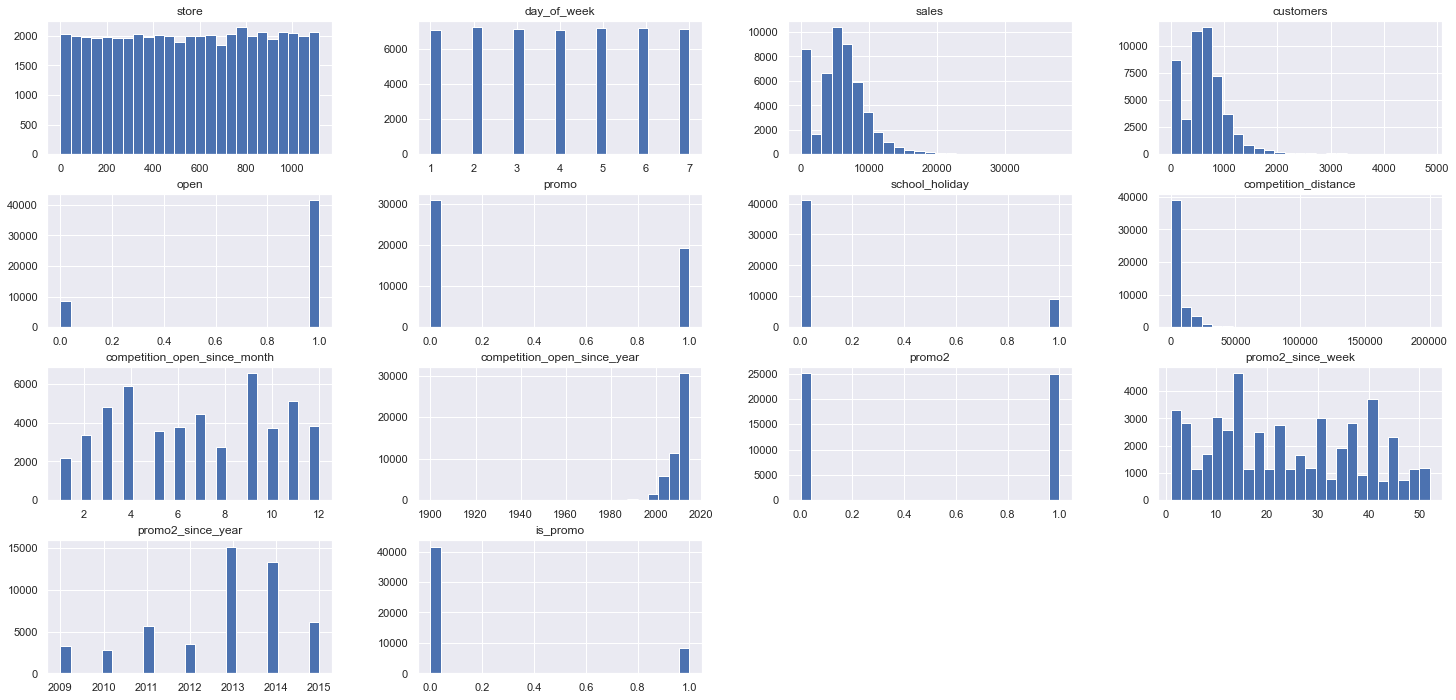

In [31]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

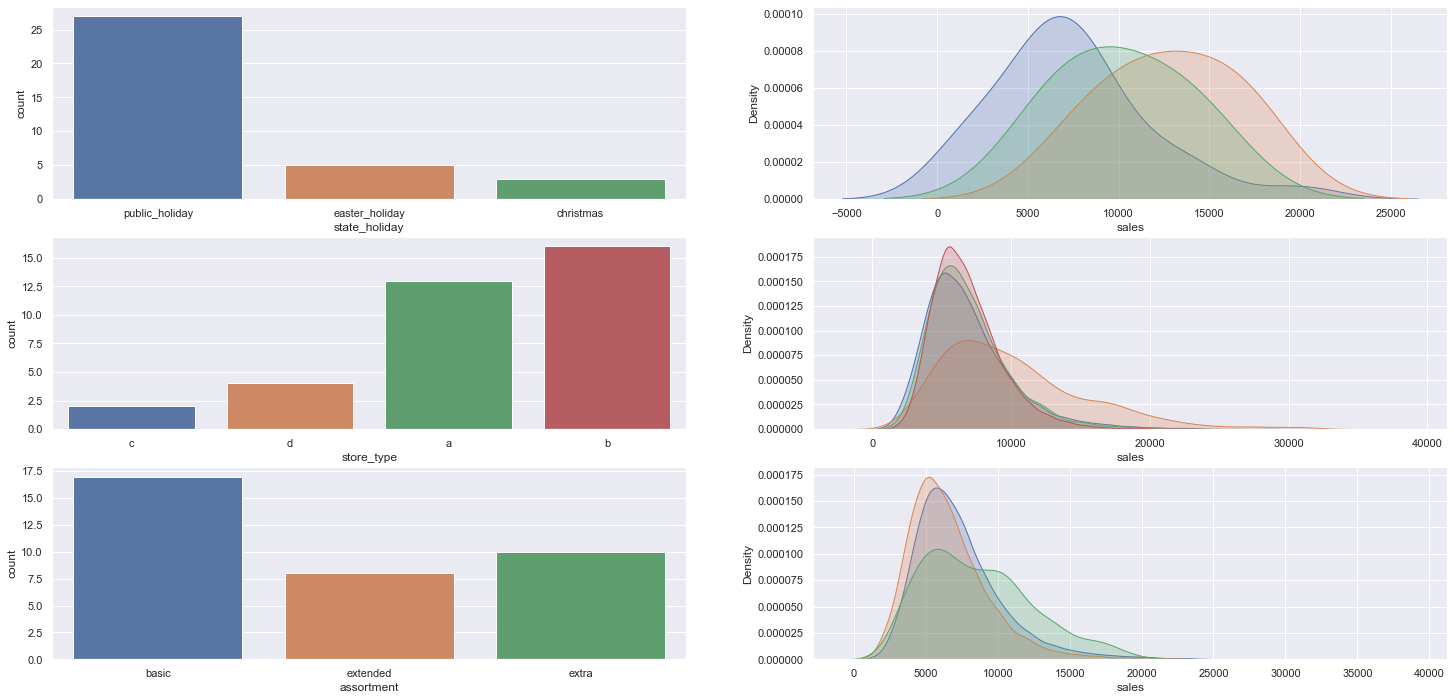

In [32]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True);

# store_stype
plt.subplot(3, 2, 3)
sns.countplot(a['store_type']);

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);

# assorment
plt.subplot(3, 2, 5)
sns.countplot(a['assortment']);

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.
**FALSA** - Lojas com maior **SORTIMENTO** vendem **MENOS**

<AxesSubplot:xlabel='year_week'>

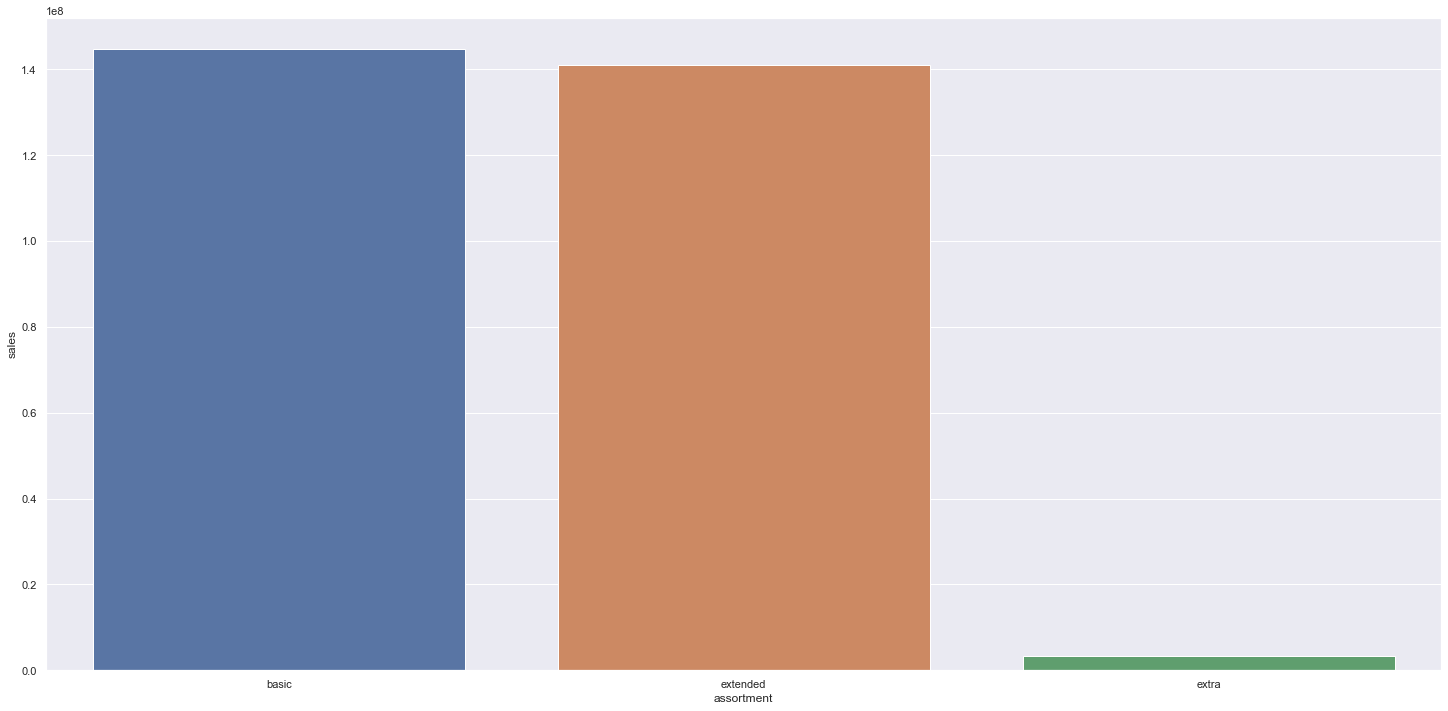

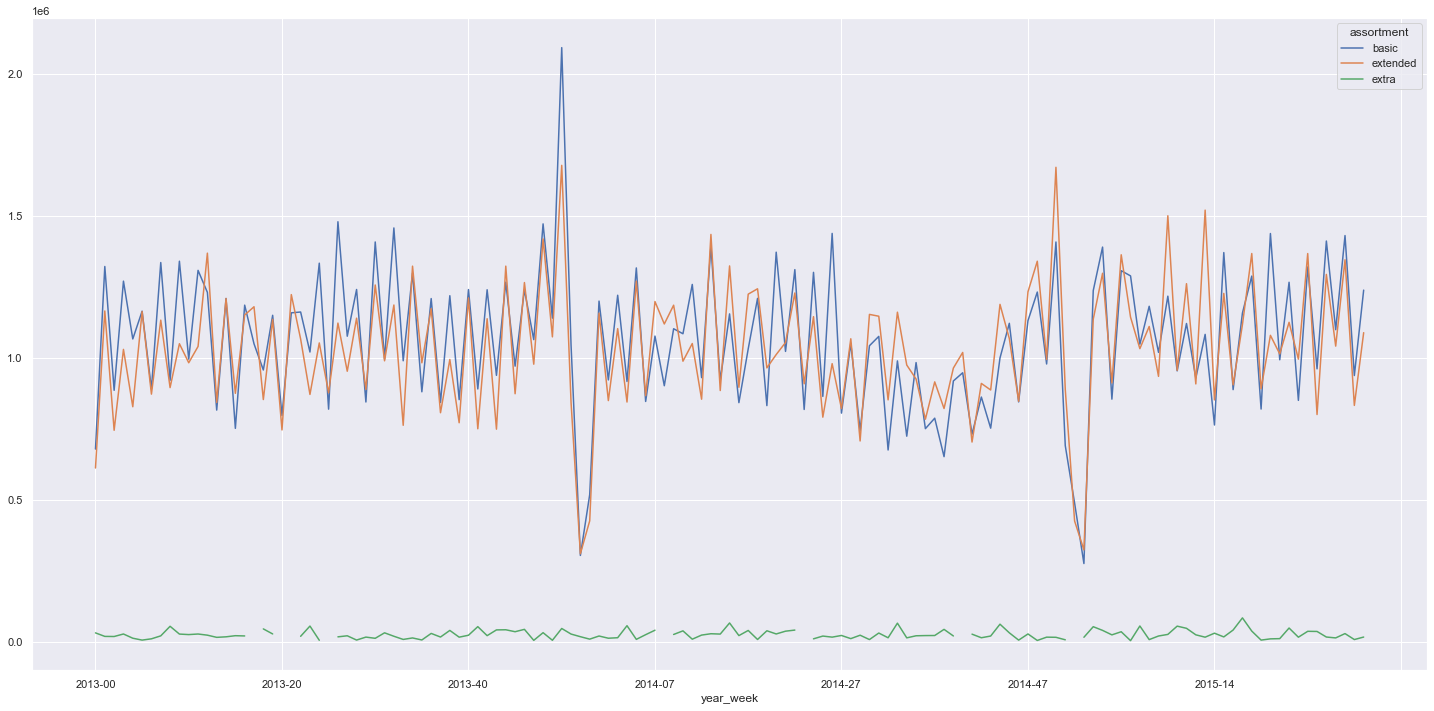

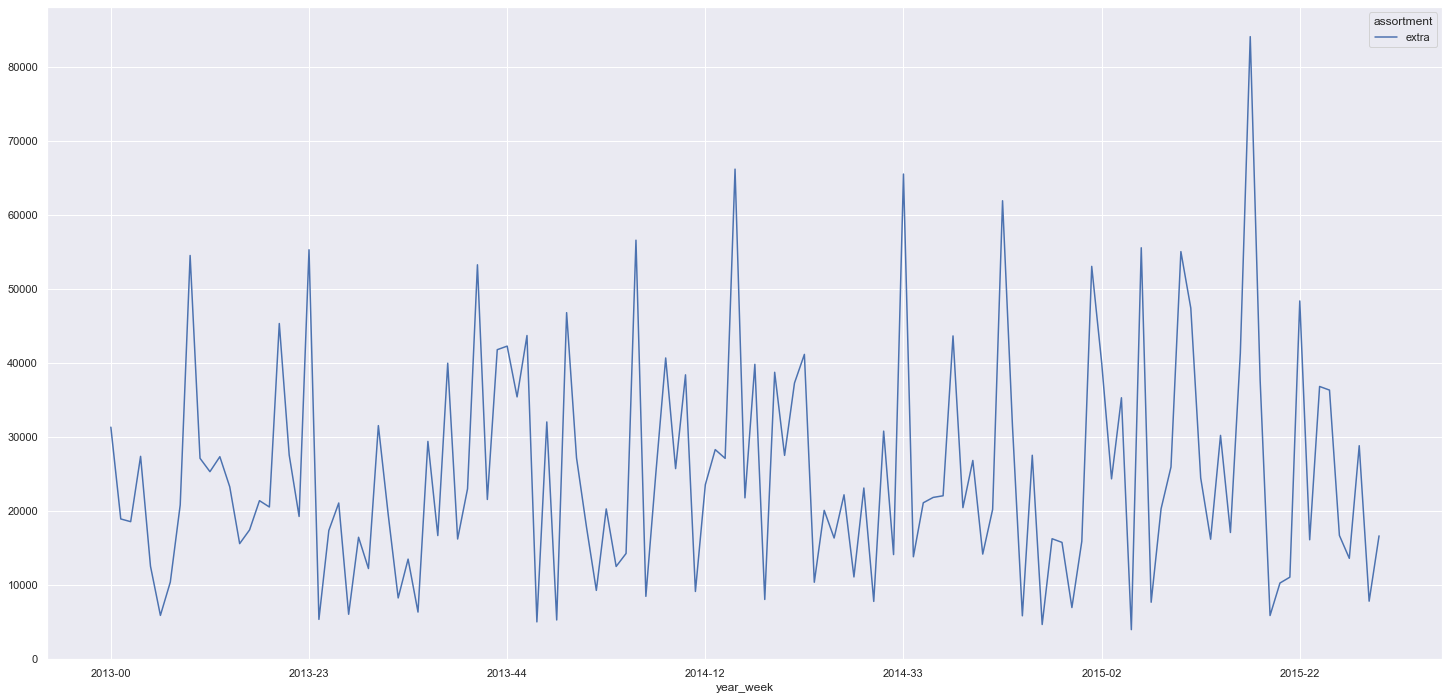

In [33]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().sort_values('sales', ascending=False).reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().sort_values('sales', ascending=False).reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

In [34]:
aux2.head()

,year_week,assortment,sales
0,2013-50,basic,2091329
1,2013-50,extended,1676934
2,2014-50,extended,1670109
3,2015-13,extended,1519317
4,2015-09,extended,1499543


### H2. Lojas com competidores mais proximos deveriam vender menos.
**FALSA** - Lojas com competidores **MAIS PRÓXIMOS** vendem **MENOS**

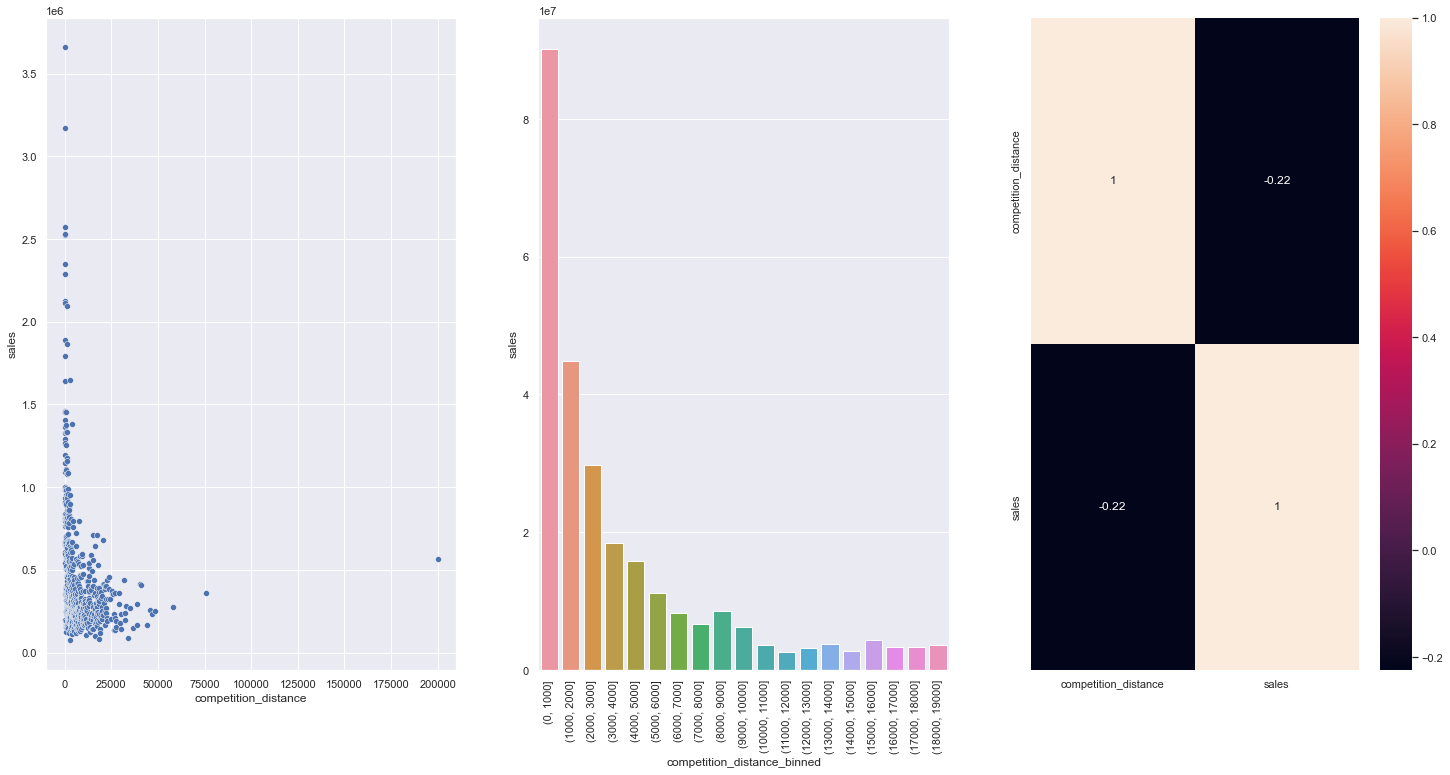

In [35]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

In [36]:
aux1.sample(5)

,competition_distance,sales,competition_distance_binned
246,3040.0,644385,"(3000, 4000]"
541,15040.0,287907,"(15000, 16000]"
339,4820.0,451826,"(4000, 5000]"
371,5650.0,263149,"(5000, 6000]"
479,9790.0,285535,"(9000, 10000]"


In [37]:
df4['competition_distance'].min()

20.0

### H3. Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** - Lojas com competidores a **MAIS TEMPO** vendem **MENOS**

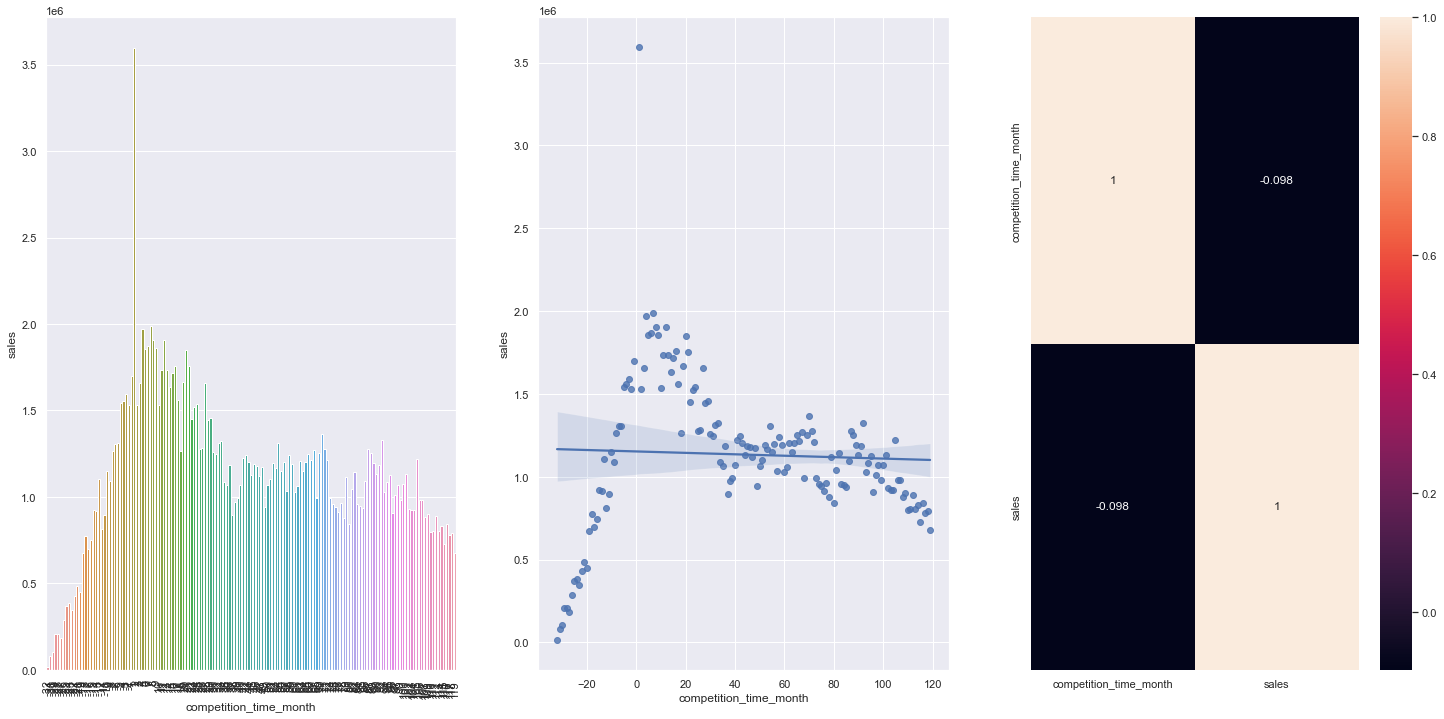

In [38]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** - Lojas com promoções ativas por **MAIS TEMPO** vendem **MENOS**, depois de um período de promoção

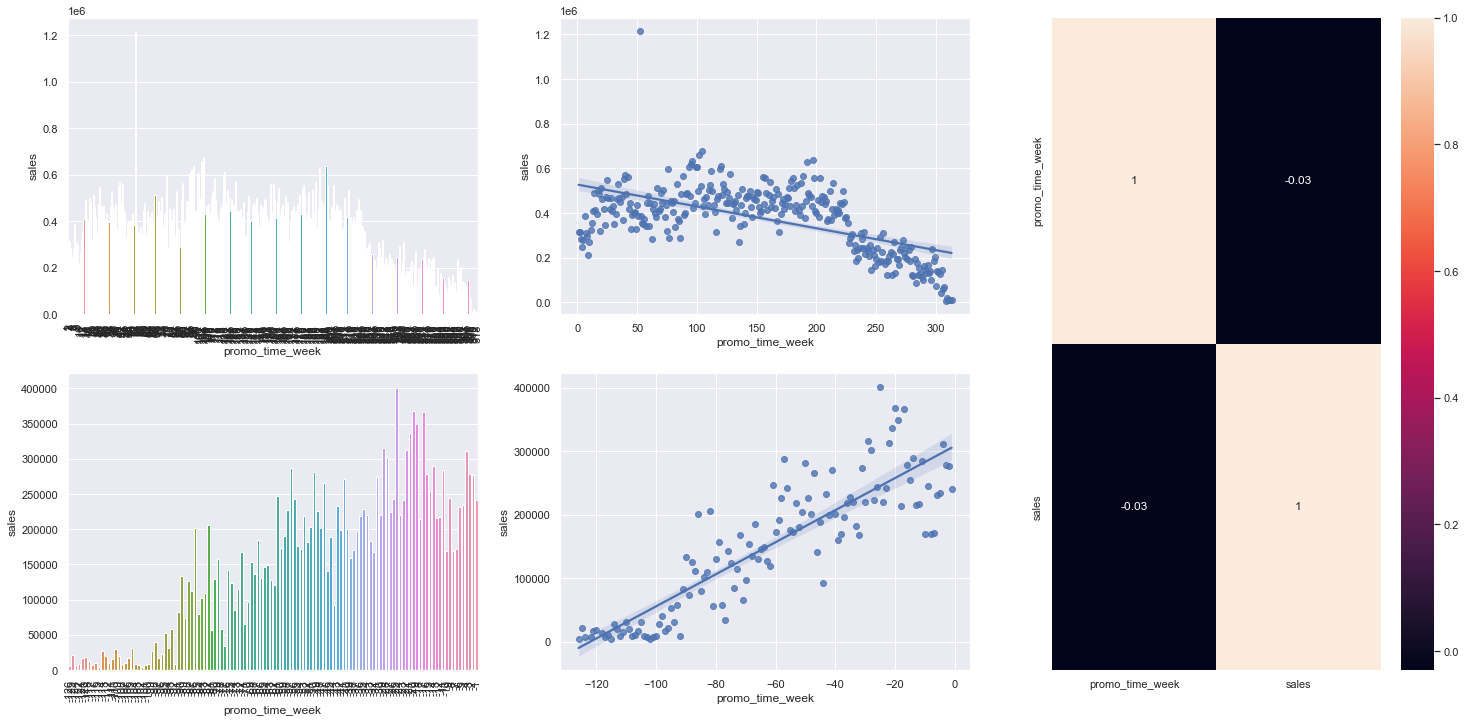

In [39]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> H5. Lojas com mais dias de promocao deveriam vender mais.</s>

### H6. Lojas com mais promocoes consecutivas deveriam vender mais.
**FALSA** - Lojas com  ativas por **MAIS PROMOÇÕES CONSECUTIVAS** vendem **MENOS**

In [40]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index().sort_values('sales', ascending=True)

,promo,promo2,sales
1,0,1,63555879
3,1,1,71393157
0,0,0,72518425
2,1,0,81627600


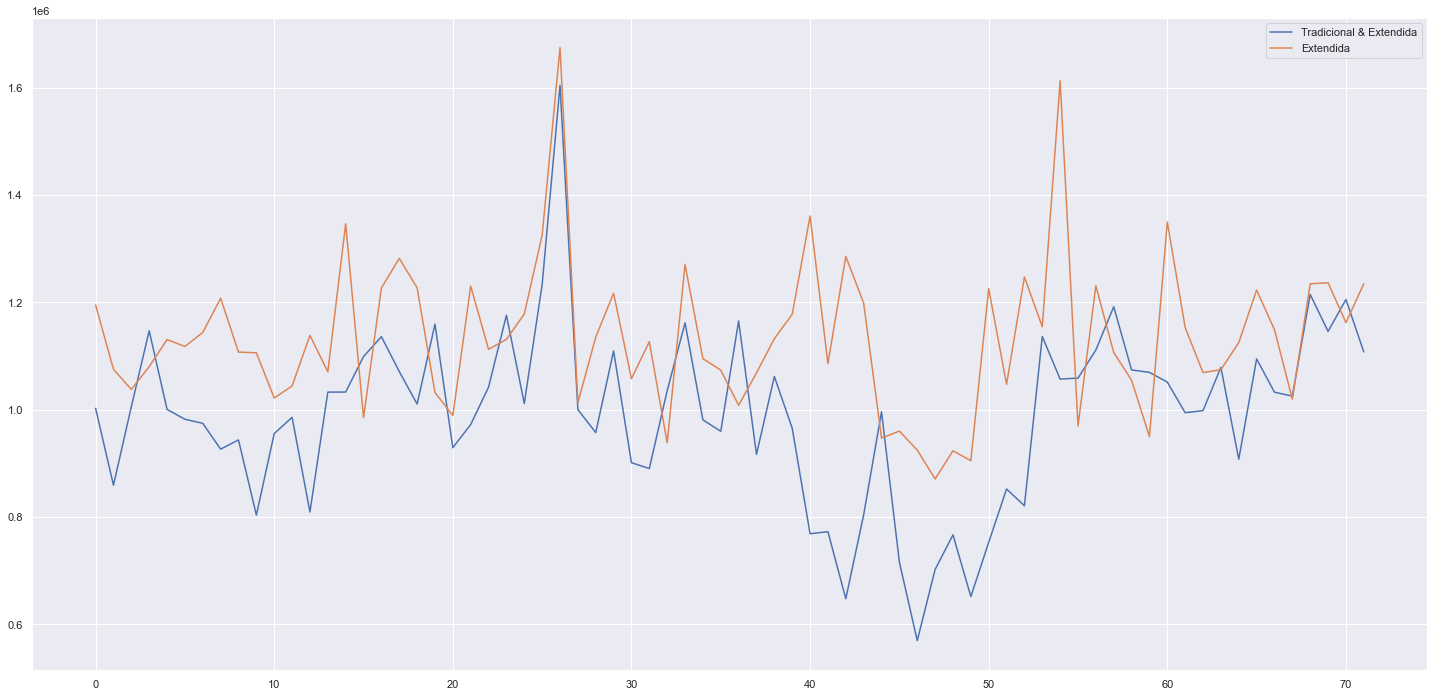

In [41]:
aux1 = df4[((df4['promo'] == 1) & (df4['promo2'] == 1))][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[((df4['promo'] == 1) & (df4['promo2'] == 0))][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de Natal **VENDEM MENOS**

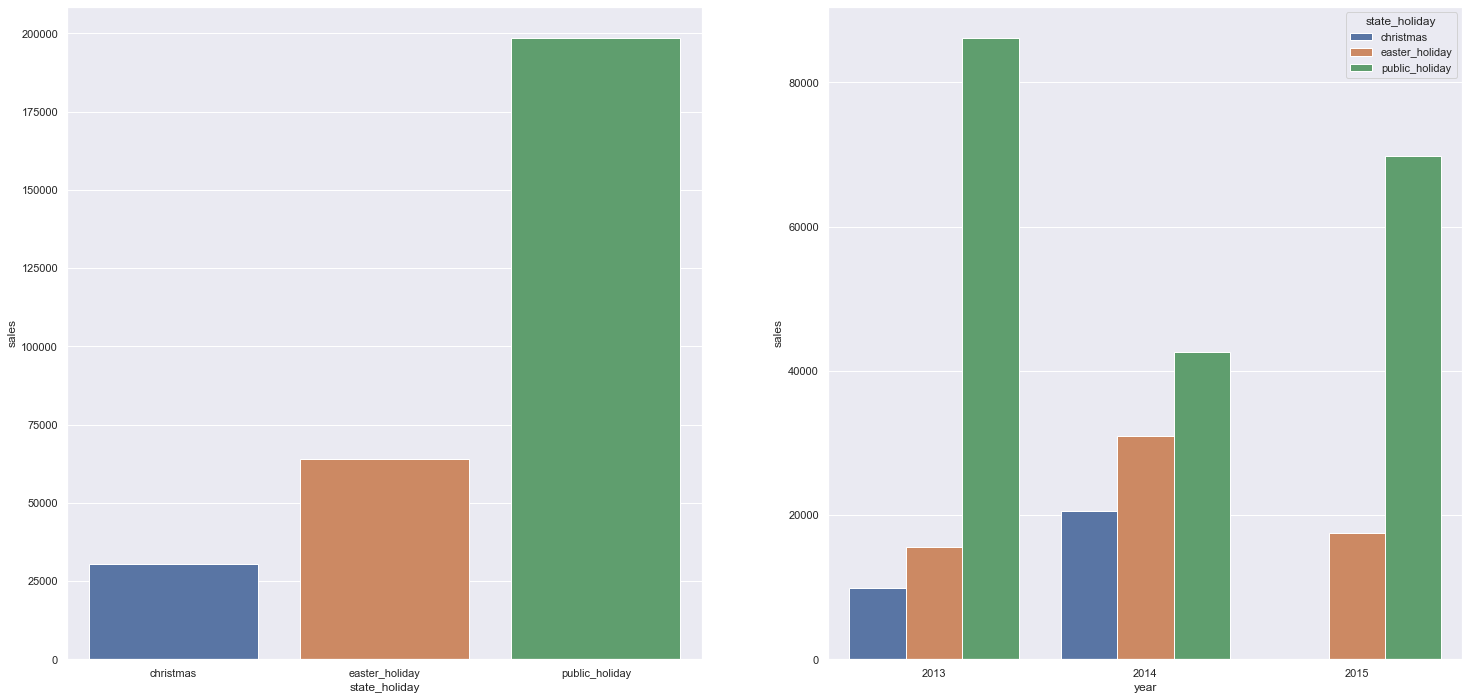

In [76]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem **MENOS** ao longo dos anos.

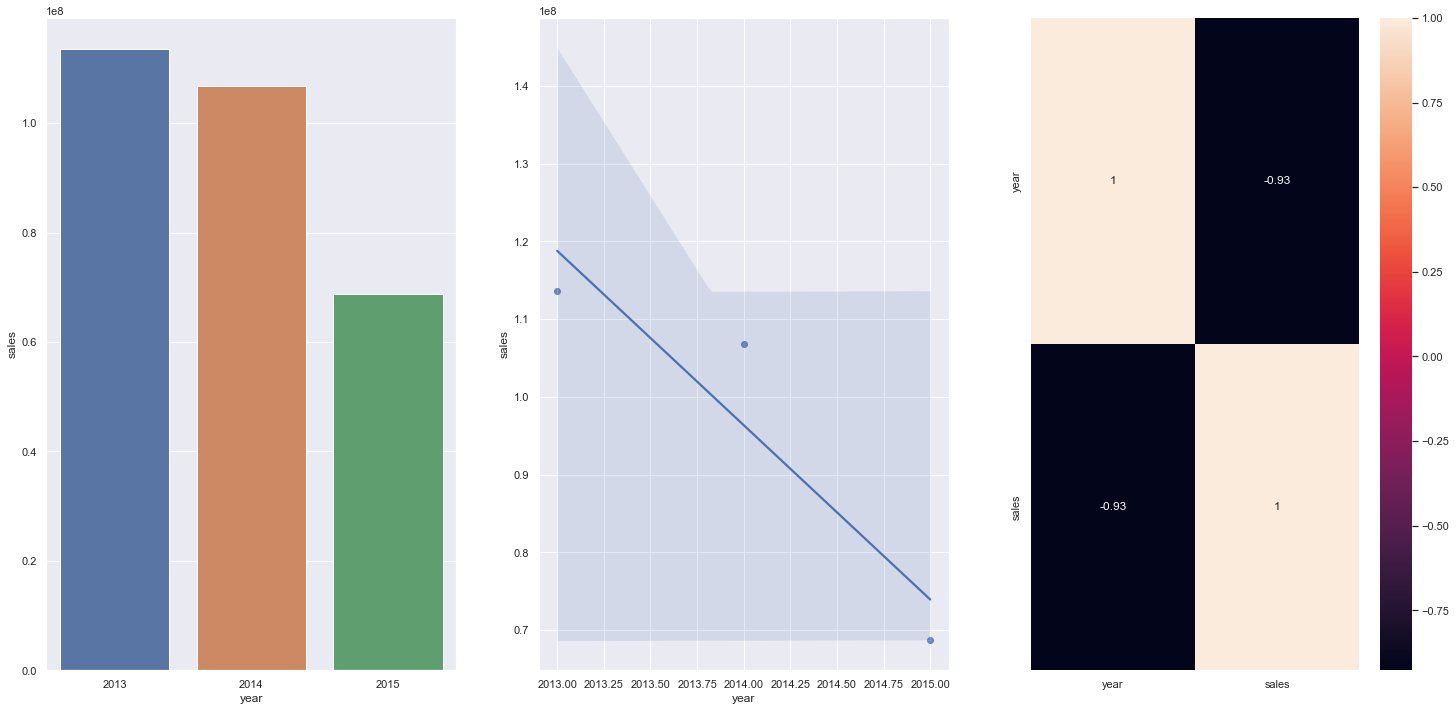

In [77]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas **VENDEM MENOS** no **SEGUNDO** semestre do ano

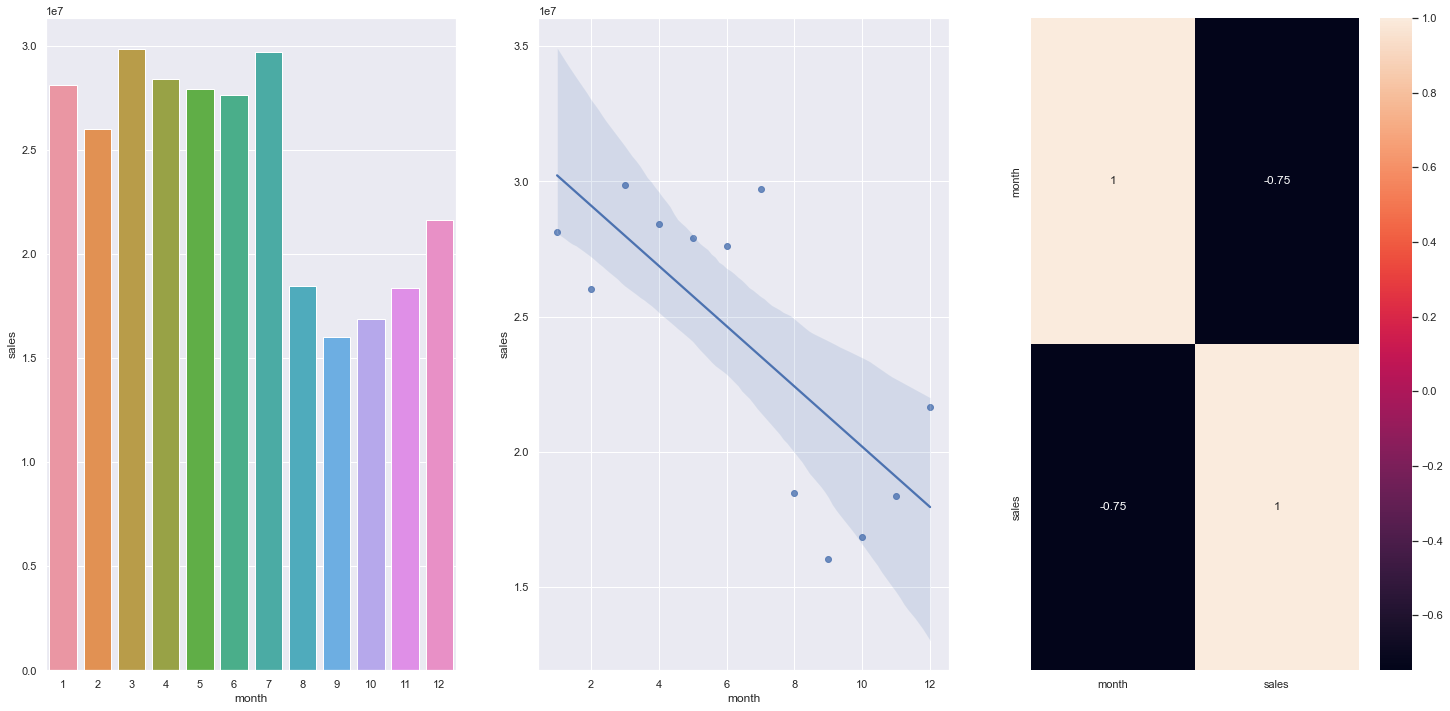

In [78]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mes.
**VERDADEIRA** Lojas **VENDEM MAIS** depois do dia 10 de cada mês

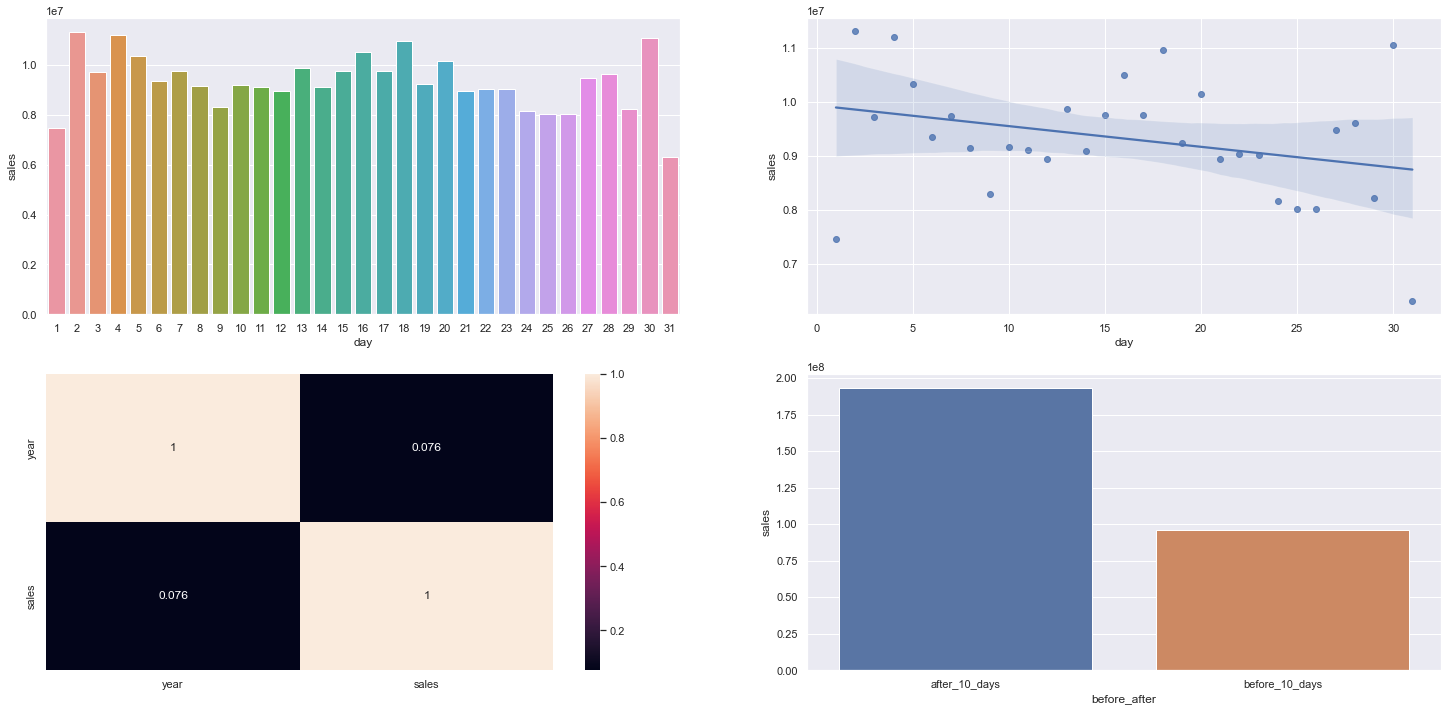

In [85]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas **VENDEM MENOS** aos finais de semana

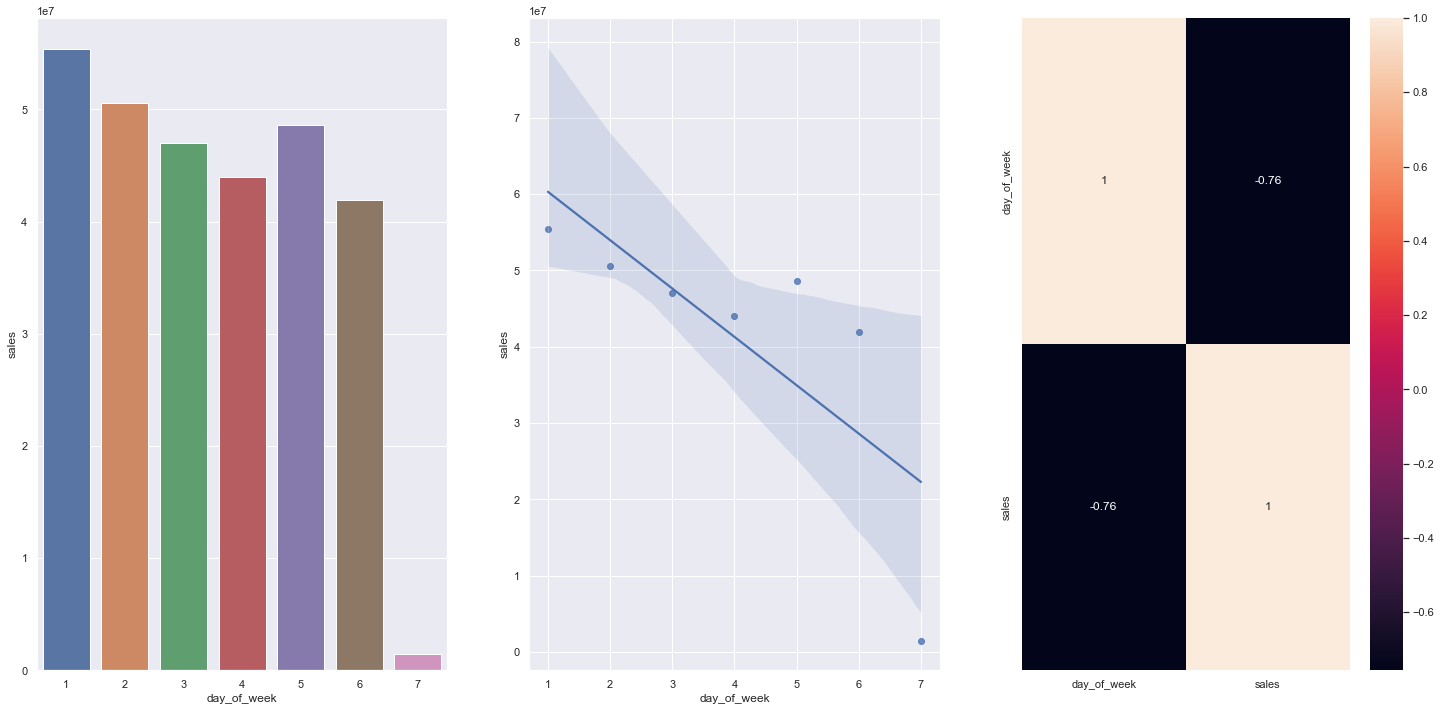

In [86]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas **VENDEM MENOS** durante os feriados escolares, **exceto** nos meses de **Julho e Agosto**

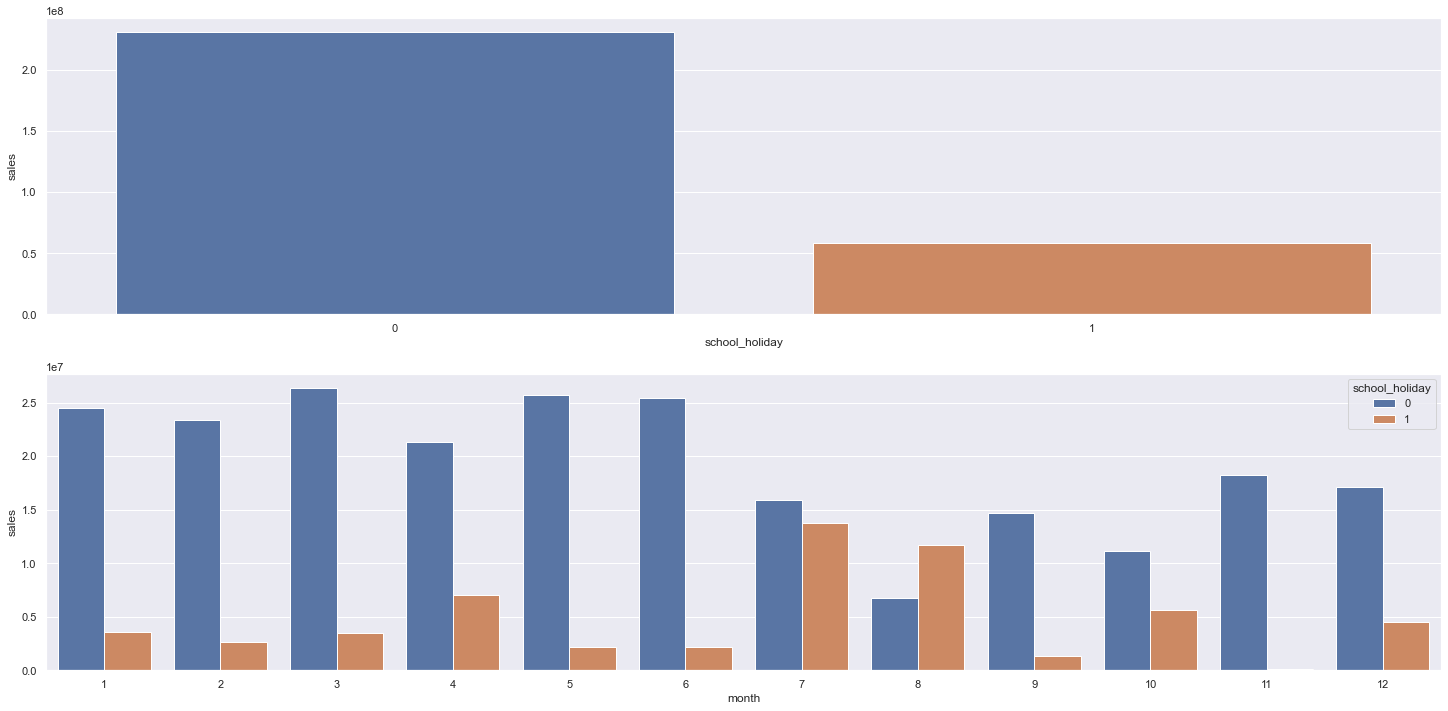

In [92]:
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

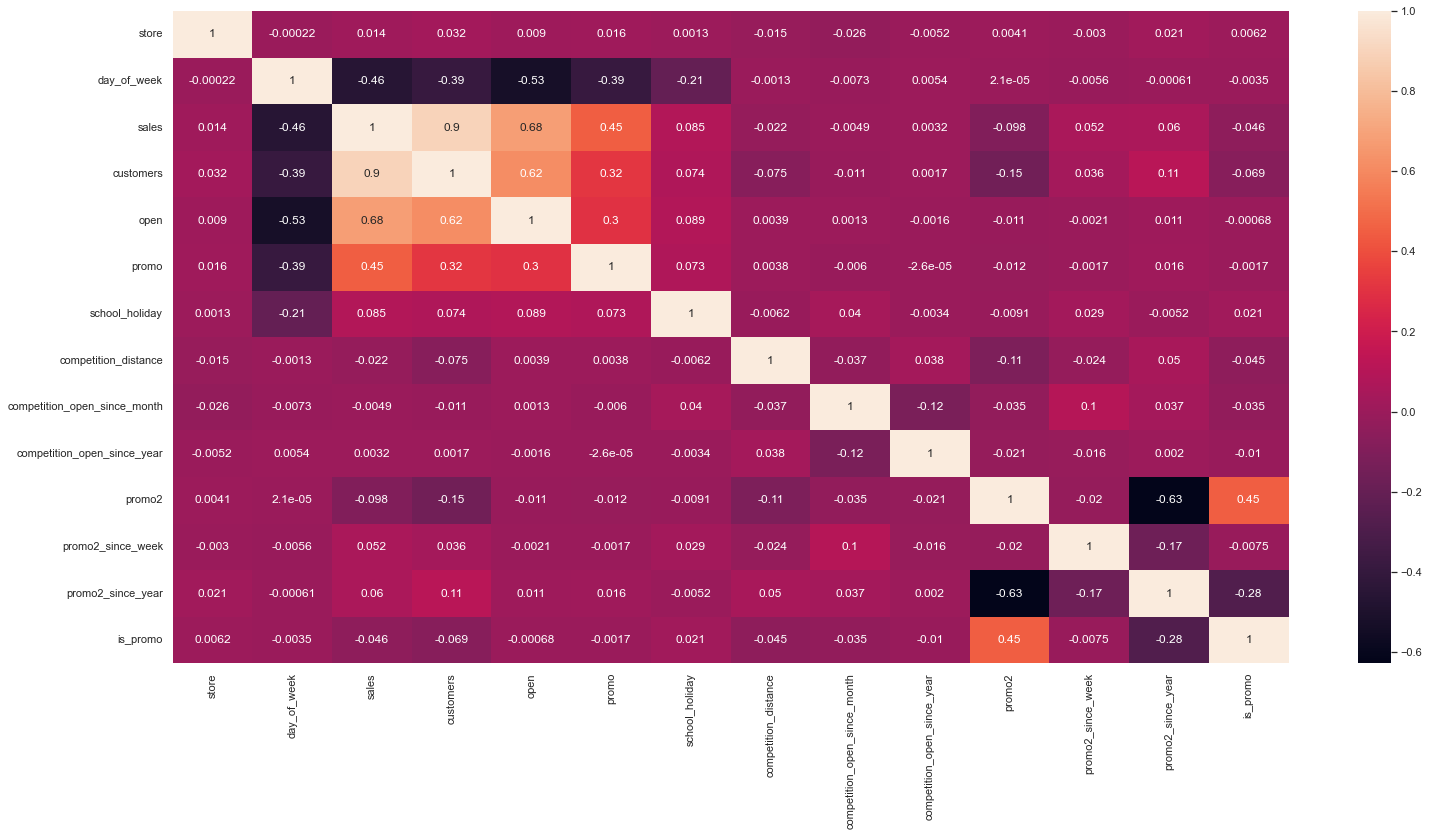

In [96]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

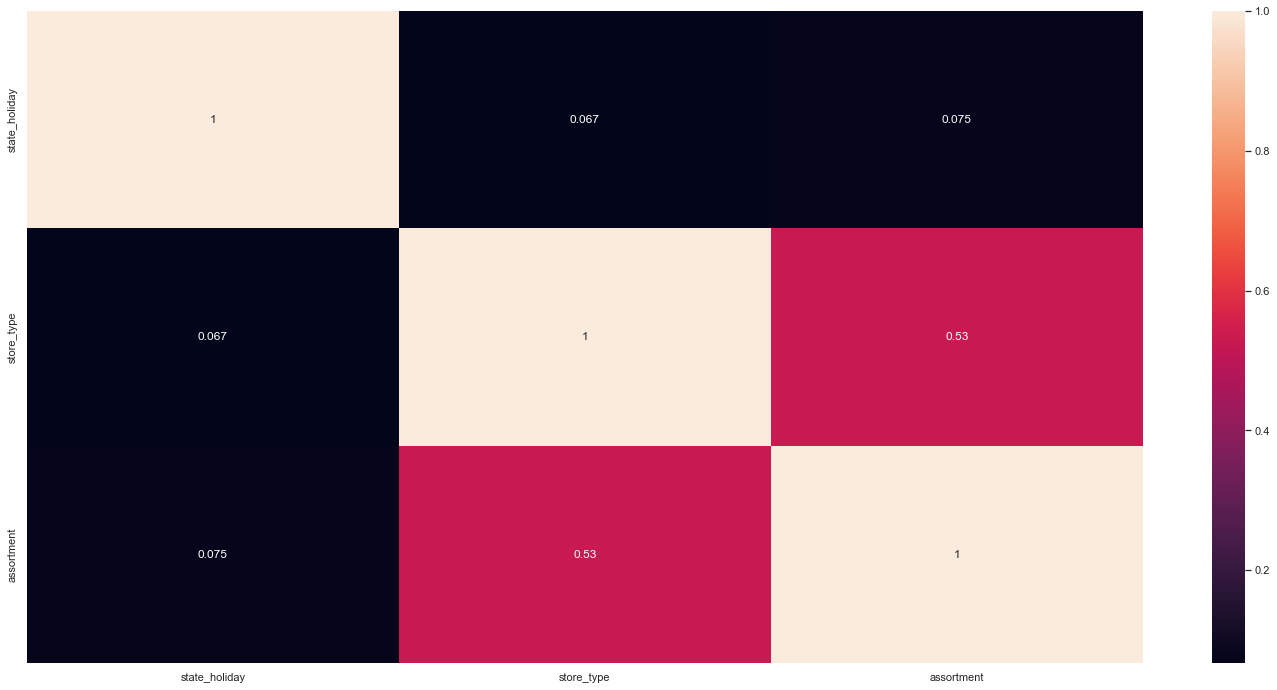

In [147]:
# Only categorical data
a = df4.select_dtypes(include='object')

# Calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final Dataset
d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]
})

d = d.set_index(d.columns)

# Plot heatmap
sns.heatmap(d, annot=True);

# 5.0. PREPARAÇÃO DOS DADOS

In [165]:
df5 = df4.copy()

## 5.1. Normalização

Não faremos nenhuma normalização pois não identificamos nenhuma distribuição Gaussiana em nossas variáveis numéricas

## 5.2. Rescaling

In [166]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3. Transformação

In [ ]:
# day of week
# month
# day
# week of year